# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'SDT', 'vanilla'
    },
    'data': {
        'number_of_variables': 9, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 5, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'random_decision_tree_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [1024, 1024, 256, 2048, 2048],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.3, 0.3, 0.3, 0.3, 0.3],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.0001,
        'loss': 'binary_crossentropy', #mse; soft_mse; binary_crossentropy; soft_binary_crossentropy; 'binary_accuracy'
        'metrics': ['soft_binary_crossentropy', 'binary_accuracy'],
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 3, # 1=standard representation; 2=sparse representation with classification for variables; 3=softmax to select classes (n top probabilities)
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
        'soft_labels': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2,3) #3=autoencoder dimensionality reduction
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 7,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable


In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type == 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 3 and dt_type == 'SDT'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var9_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1024-1024-256-2048-2048_drop0.3-0.3-0.3-0.3-0.3e500b256_adam
lNetSize5000_numLNets10000_var9_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth5_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
       
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              config) for network_parameters_row in network_parameters.values)          
    del parallel
    
    base_model = generate_base_model(config)  
    
    #def initialize_network_wrapper(config, lambda_net, base_model):
    #    lambda_net.initialize_network(config, base_model)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    #del parallel
    
    #def initialize_target_function_wrapper(config, lambda_net):
    #    lambda_net.initialize_target_function(config)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    #del parallel
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    
    if False:
        lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
        lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_train_with_valid = load_lambda_nets(config_train, n_jobs=n_jobs)
        lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

        _, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)   
        
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:    5.8s
[Parallel(n_jobs=7)]: Done 1038 tasks      | elapsed:    6.2s
[Parallel(n_jobs=7)]: Done 9892 tasks      | elapsed:    9.4s
[Parallel(n_jobs=7)]: Done 10000 out of 10000 | elapsed:    9.5s finished


## Data Inspection

In [12]:
lambda_net_dataset_train.shape

(8955, 1433)

In [13]:
lambda_net_dataset_valid.shape

(995, 1433)

In [14]:
lambda_net_dataset_test.shape

(50, 1433)

In [15]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,...,wb_1309,wb_1310,wb_1311,wb_1312,wb_1313,wb_1314,wb_1315,wb_1316,wb_1317,wb_1318,wb_1319,wb_1320,wb_1321,wb_1322,wb_1323,wb_1324,wb_1325,wb_1326,wb_1327,wb_1328,wb_1329,wb_1330,wb_1331,wb_1332,wb_1333,wb_1334,wb_1335,wb_1336,wb_1337,wb_1338,wb_1339,wb_1340,wb_1341,wb_1342,wb_1343,wb_1344,wb_1345,wb_1346,wb_1347,wb_1348,wb_1349,wb_1350,wb_1351,wb_1352,wb_1353,wb_1354,wb_1355,wb_1356,wb_1357,wb_1358,wb_1359,wb_1360,wb_1361,wb_1362,wb_1363,wb_1364,wb_1365,wb_1366,wb_1367,wb_1368,wb_1369,wb_1370,wb_1371,wb_1372,wb_1373,wb_1374,wb_1375,wb_1376,wb_1377,wb_1378,wb_1379,wb_1380,wb_1381,wb_1382,wb_1383,wb_1384,wb_1385,wb_1386,wb_1387,wb_1388,wb_1389,wb_1390,wb_1391,wb_1392,wb_1393,wb_1394,wb_1395,wb_1396,wb_1397,wb_1398,wb_1399,wb_1400,wb_1401,wb_1402,wb_1403,wb_1404,wb_1405,wb_1406,wb_1407,wb_1408
6671,6671.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.042,0.220,-0.213,-0.233,-0.405,0.072,0.183,0.020,-0.035,-0.187,0.223,-0.096,0.222,0.200,0.088,0.079,-0.251,-0.056,0.218,-0.052,-0.092,-0.120,-0.018,-0.222,-0.148,-0.179,-0.008,-0.076,-0.186,-0.343,-0.083,-0.035,0.120,-0.165,0.240,0.079,-0.208,-0.034,0.097,-0.560,-0.149,0.093,0.072,0.083,0.193,0.090,-0.007,-0.200,0.013,-0.698,0.194,-0.129,0.218,-0.109,0.052,0.002,-0.129,0.187,-0.050,0.140,0.223,0.026,-0.363,0.165,-0.165,-0.154,0.138,0.269,0.066,-0.104,-0.135,-0.065,-0.188,0.051,0.151,-0.101,...,0.885,-0.085,0.364,0.154,1.100,-0.607,0.719,1.208,0.648,1.493,-1.269,1.470,1.183,0.096,0.108,0.847,0.098,0.249,-1.179,0.931,-1.636,1.520,-0.133,-0.930,-0.113,-1.392,0.986,0.198,-0.478,-0.497,0.910,-0.461,1.074,-0.427,1.080,0.678,-0.749,1.173,-0.851,-0.057,-0.107,0.756,0.913,1.232,-0.340,-0.084,-0.709,-0.399,-0.426,0.392,-0.559,-0.184,-0.422,-0.176,0.471,-0.368,-0.659,-1.195,0.704,-0.248,0.420,0.257,-0.996,-0.922,0.092,0.034,-0.418,-1.387,0.463,0.265,-0.367,-1.152,-2.511,-0.317,-0.106,0.140,0.033,0.085,1.031,-1.106,-2.220,1.277,-0.260,-0.810,0.402,0.090,-2.492,-1.179,1.207,0.067,0.138,-0.095,0.740,-0.063,-0.338,-0.880,1.386,-0.832,-0.180,-0.137
3274,3274.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.002,-0.158,-0.050,0.055,0.016,0.152,0.061,0.046,0.015,-0.187,0.157,0.026,0.084,0.024,0.007,-0.229,-0.113,-0.113,0.119,0.011,-0.049,-0.088,0.031,0.023,0.099,-0.074,0.074,0.007,0.021,-0.024,-0.083,-0.086,0.015,-0.178,0.217,-0.027,-0.045,0.136,-0.154,-0.144,-0.084,-0.013,-0.029,-0.012,0.140,0.070,0.091,-0.237,-0.031,0.001,0.149,-0.129,-0.034,-0.109,-0.096,0.178,-0.076,0.021,-0.217,-0.032,0.272,-0.007,0.033,0.032,0.026,0.030,0.013,-0.061,-0.024,-0.116,0.061,0.051,-0.030,0.055,0.031,-0.120,...,0.716,-0.085,1.265,0.820,0.157,-1.634,0.638,0.544,0.620,0.609,-0.762,0.548,0.710,0.653,0.606,0.647,0.067,0.130,-0.166,0.795,-0.909,0.710,-0.133,-0.816,-0.113,0.034,0.702,-0.026,-0.688,-0.785,1.378,-0.313,0.545,-0.505,0.895,-0.248,-0.754,-0.594,0.741,-0.480,-0.098,-0.366,0.729,0.574,-0.509,-0.567,-0.525,-0.436,0.012,1.194,-1.717,-0.476,-0.779,-1.136,0.781,-0.578,-0.511,-0.149,0.916,-0.216,0.604,0.475,-0.631,-0.982,0.011,1.833,-0.449,-0.229,0.845,-0.368,-0.604,-1.265,-0.279,-1.260,-0.106,0.041,0.672,0.971,0.587,-0.747,-0.319,0.067,-0.399,-0.665,0.274,-0.345,-2.502,-0.712,0.997,0.740,0.913,0.455,0.503,-0.250,-0.336,-0.804,1.265,-0.421,0.370,0.059
3095,3095.000,

In [16]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,...,wb_1309,wb_1310,wb_1311,wb_1312,wb_1313,wb_1314,wb_1315,wb_1316,wb_1317,wb_1318,wb_1319,wb_1320,wb_1321,wb_1322,wb_1323,wb_1324,wb_1325,wb_1326,wb_1327,wb_1328,wb_1329,wb_1330,wb_1331,wb_1332,wb_1333,wb_1334,wb_1335,wb_1336,wb_1337,wb_1338,wb_1339,wb_1340,wb_1341,wb_1342,wb_1343,wb_1344,wb_1345,wb_1346,wb_1347,wb_1348,wb_1349,wb_1350,wb_1351,wb_1352,wb_1353,wb_1354,wb_1355,wb_1356,wb_1357,wb_1358,wb_1359,wb_1360,wb_1361,wb_1362,wb_1363,wb_1364,wb_1365,wb_1366,wb_1367,wb_1368,wb_1369,wb_1370,wb_1371,wb_1372,wb_1373,wb_1374,wb_1375,wb_1376,wb_1377,wb_1378,wb_1379,wb_1380,wb_1381,wb_1382,wb_1383,wb_1384,wb_1385,wb_1386,wb_1387,wb_1388,wb_1389,wb_1390,wb_1391,wb_1392,wb_1393,wb_1394,wb_1395,wb_1396,wb_1397,wb_1398,wb_1399,wb_1400,wb_1401,wb_1402,wb_1403,wb_1404,wb_1405,wb_1406,wb_1407,wb_1408
3466,3466.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.467,0.685,-0.327,-0.206,0.184,0.012,0.054,0.437,-0.037,-0.187,0.275,-0.019,0.571,0.435,0.089,0.069,-0.647,0.354,0.708,0.338,-0.129,0.618,0.661,-0.537,-0.483,-0.483,0.585,0.106,-0.176,0.118,-0.083,-0.159,0.126,-0.317,0.080,0.809,-0.605,0.600,0.140,-0.145,-1.203,-1.923,0.100,-0.336,0.681,0.086,0.164,-0.030,0.137,-0.031,-1.922,-0.129,0.183,-0.109,0.030,0.321,-0.510,0.010,0.385,0.080,0.116,0.562,0.239,0.850,0.725,0.386,-0.788,0.581,0.326,-0.111,0.659,0.106,0.109,-0.089,0.575,0.148,...,0.401,-0.085,0.108,0.145,0.458,-1.324,1.687,0.452,1.255,0.752,-1.224,0.720,2.552,0.118,1.331,1.687,0.087,0.486,-1.432,0.235,-1.138,2.563,-0.133,-0.585,-0.113,-0.146,1.250,0.254,-0.483,-0.536,0.103,-0.942,1.255,-0.166,1.711,-0.622,-1.162,0.529,-0.791,-0.225,-0.100,-0.683,0.139,-0.535,-0.295,-0.210,-0.332,-0.616,1.766,0.422,-0.137,-0.548,-0.641,-0.348,0.532,-0.593,-0.472,-1.463,2.204,-0.150,-0.503,1.232,-0.653,-0.592,0.203,0.656,-0.571,-0.367,1.066,0.366,-0.080,-1.203,-0.191,-0.526,-0.106,0.209,0.572,0.081,0.976,-0.745,-0.735,0.067,-0.584,-0.657,1.280,-0.255,-0.203,-0.618,1.668,0.489,0.130,0.318,1.363,-0.150,-0.633,-0.896,0.083,0.410,-0.381,-0.092
689,689.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.074,-0.007,0.026,0.064,-0.034,0.187,0.065,-0.005,0.183,-0.187,-0.039,-0.109,0.079,0.005,0.094,0.073,-0.009,0.032,-0.063,0.002,0.065,0.062,-0.006,-0.044,0.027,-0.068,-0.113,0.055,0.005,0.027,-0.083,0.110,0.002,-0.037,-0.102,0.040,-0.017,0.155,-0.045,0.126,0.074,-0.012,0.110,0.004,0.449,0.152,0.105,-0.246,0.015,0.171,0.158,-0.129,-0.060,-0.109,-0.225,-0.032,-0.067,0.087,-0.070,0.020,0.129,0.059,-0.122,0.285,-0.106,0.063,-0.015,0.012,0.030,-0.104,0.086,0.157,-0.014,0.126,-0.341,0.143,...,0.629,-0.085,0.359,0.781,0.293,-0.062,1.315,-1.898,0.164,0.394,-1.501,-0.255,0.704,0.480,0.597,1.409,0.433,0.340,-0.170,0.455,-1.090,1.672,-0.133,-2.516,-0.113,0.275,0.305,0.092,-2.003,-2.098,0.528,-2.093,0.554,-1.783,0.948,0.136,-2.107,0.311,-1.935,-1.049,-0.107,-0.492,0.449,-0.236,-0.926,0.426,-0.679,-0.538,0.354,0.267,-0.139,-0.641,-2.346,-1.956,0.363,-0.470,-1.631,-2.314,0.048,-0.549,0.503,0.297,-1.010,-0.749,0.068,0.346,0.940,-0.658,0.178,0.131,-0.937,-2.021,-2.554,-1.868,-0.106,0.236,0.349,0.867,0.902,-1.431,-1.288,0.063,-1.688,-0.564,0.834,-0.716,-0.203,-1.605,0.408,0.638,0.784,0.147,0.645,-0.644,0.334,-0.424,0.401,0.302,-1.976,0.183
4148,4148.000,42,0.000,0.000,0.000,

In [17]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,...,wb_1309,wb_1310,wb_1311,wb_1312,wb_1313,wb_1314,wb_1315,wb_1316,wb_1317,wb_1318,wb_1319,wb_1320,wb_1321,wb_1322,wb_1323,wb_1324,wb_1325,wb_1326,wb_1327,wb_1328,wb_1329,wb_1330,wb_1331,wb_1332,wb_1333,wb_1334,wb_1335,wb_1336,wb_1337,wb_1338,wb_1339,wb_1340,wb_1341,wb_1342,wb_1343,wb_1344,wb_1345,wb_1346,wb_1347,wb_1348,wb_1349,wb_1350,wb_1351,wb_1352,wb_1353,wb_1354,wb_1355,wb_1356,wb_1357,wb_1358,wb_1359,wb_1360,wb_1361,wb_1362,wb_1363,wb_1364,wb_1365,wb_1366,wb_1367,wb_1368,wb_1369,wb_1370,wb_1371,wb_1372,wb_1373,wb_1374,wb_1375,wb_1376,wb_1377,wb_1378,wb_1379,wb_1380,wb_1381,wb_1382,wb_1383,wb_1384,wb_1385,wb_1386,wb_1387,wb_1388,wb_1389,wb_1390,wb_1391,wb_1392,wb_1393,wb_1394,wb_1395,wb_1396,wb_1397,wb_1398,wb_1399,wb_1400,wb_1401,wb_1402,wb_1403,wb_1404,wb_1405,wb_1406,wb_1407,wb_1408
7217,7217.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.135,-0.056,-0.045,0.053,-0.026,-0.045,0.036,-0.161,0.066,-0.187,0.126,0.239,-0.068,0.080,0.094,0.216,0.101,-0.424,-0.202,-0.171,-0.281,-0.117,-0.062,-0.040,0.106,-0.029,0.095,0.083,-0.187,0.007,-0.083,0.090,0.125,0.058,0.088,0.045,-0.045,0.111,0.015,0.073,-0.035,0.074,0.075,0.071,0.113,0.161,0.105,-0.057,0.049,-0.204,0.125,-0.129,-0.302,-0.109,0.119,0.022,-0.043,0.094,-0.272,0.230,-0.102,0.294,-0.060,0.349,0.019,-0.145,0.103,-0.031,-0.190,-0.104,0.099,0.133,0.045,0.060,0.187,-0.671,...,-1.170,-0.085,0.096,0.146,0.158,-1.066,0.283,0.215,0.345,-0.806,-1.189,0.153,0.023,0.099,0.101,0.269,3.200,0.134,-0.785,0.072,-0.626,0.349,-0.133,-0.356,-0.113,-0.911,0.313,0.219,-1.180,-1.106,1.171,-0.067,0.622,-0.363,1.309,0.271,-0.135,-1.105,0.541,-0.333,-0.107,-1.081,0.288,0.252,-1.181,-0.195,-1.110,0.481,-1.117,0.446,-1.594,0.251,-1.033,-1.136,0.200,0.192,-2.787,-0.851,0.413,0.006,-0.135,0.195,-0.487,-1.222,0.117,0.257,-1.012,-0.892,0.266,0.108,-0.538,-0.457,-0.922,-0.658,-0.106,0.280,0.197,0.511,0.796,-0.817,-0.992,0.067,-1.142,-0.111,0.335,0.112,-0.188,-0.240,3.109,0.050,0.129,0.547,0.140,0.039,-1.063,-2.343,1.970,-0.432,0.565,0.054
8291,8291.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.071,0.220,0.008,-0.039,-0.076,0.063,0.164,0.031,0.115,-0.187,0.110,0.182,-0.076,0.040,0.087,0.221,0.049,0.110,0.148,-0.458,-1.415,0.476,0.012,-0.039,-0.146,0.169,0.041,-0.168,-0.064,-0.169,-0.083,0.185,0.069,0.258,-0.098,0.201,-0.068,0.152,0.129,-0.244,0.004,0.267,0.408,0.028,0.496,-0.078,0.134,-0.106,0.121,0.068,0.113,-0.129,0.026,-0.109,-0.083,0.127,-0.005,-0.150,0.041,0.068,0.022,0.249,0.100,-0.049,-0.050,-0.396,-0.248,0.019,-0.023,-0.104,-0.267,-0.031,-0.054,-0.545,0.046,-0.039,...,2.669,-0.085,0.755,3.364,1.151,-0.052,3.851,0.494,0.590,1.056,-0.172,-1.452,1.318,1.339,3.444,3.517,3.412,1.234,-4.572,1.583,-0.766,2.933,-0.133,-0.128,-0.113,0.478,1.022,0.683,-0.093,-0.076,1.991,-1.765,1.248,-0.308,1.940,0.650,-3.368,0.178,-1.422,-0.783,-0.107,2.049,0.865,0.607,-2.321,-1.469,-4.414,-0.107,0.636,1.278,-0.364,-1.036,-2.028,-0.104,0.869,-0.700,-0.664,-2.768,0.969,0.144,2.676,0.193,-1.607,-0.998,0.381,0.407,-0.239,-0.023,0.653,0.181,-0.174,-0.404,-1.695,-3.688,-0.106,0.663,0.817,3.770,3.609,-0.159,2.389,0.067,-0.931,-0.559,1.821,-0.491,-0.196,-0.189,1.163,3.453,3.473,0.580,1.622,1.700,0.106,-1.830,1.197,0.165,-0.106,-0.141
4607,4607.000,42,0.000,0.000,0.000,0.

## Interpretation Network Training

In [18]:
#%load_ext tensorboard
#%tensorboard --logdir data/logging/ --port=8811

In [19]:
#%load_ext autoreload

In [20]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['tensorboard'] #plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/500
35/35 - 25s - loss: 0.6771 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6810 - binary_accuracy_inet_decision_function_fv_metric: 0.5777 - val_loss: 0.6532 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6677 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6267
Epoch 2/500
35/35 - 6s - loss: 0.6526 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6661 - binary_accuracy_inet_decision_function_fv_metric: 0.6267 - val_loss: 0.6440 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6633 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6340
Epoch 3/500
35/35 - 6s - loss: 0.6431 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6604 - binary_accuracy_inet_decision_function_fv_metric: 0.6344 - val_loss: 0.6287 - val_soft_binary_crossentropy_inet_decision_function

<Figure size 432x288 with 0 Axes>

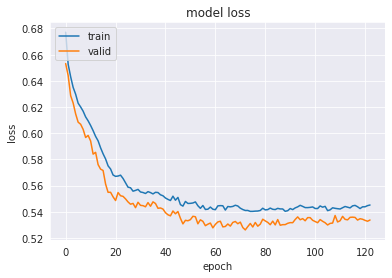

In [21]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')
            
            

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

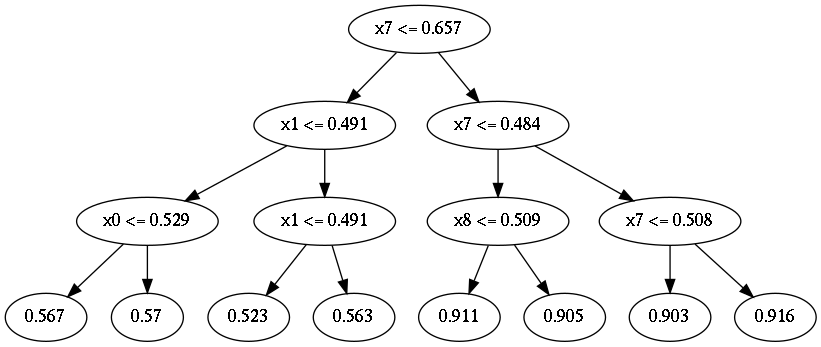

In [22]:
index = 3
network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1409)]       0                                            
__________________________________________________________________________________________________
hidden1_1024 (Dense)            (None, 1024)         1443840     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 1024)         0           hidden1_1024[0][0]               
__________________________________________________________________________________________________
dropout1_0.3 (Dropout)          (None, 1024)         0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [24]:
with tf.device('/CPU:0'):
    number = min(lambda_net_dataset_train.X_test_lambda_array.shape[0], 100)

    start_inet = time.time() 
    
    network_parameters = np.array(lambda_net_dataset_train.network_parameters_array[:number])
    if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
    elif config['i_net']['data_reshape_version'] == 3: #autoencoder
        network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
    dt_inet_list = model.predict(network_parameters)   
    
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    

    
    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=10, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_train.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_train.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict_train = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict_train == None:
            inet_evaluation_result_dict_train = some_dict
        else:
            inet_evaluation_result_dict_train = mergeDict(inet_evaluation_result_dict_train, some_dict)

    inet_evaluation_result_dict_train['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean_train = {}

    for key_l1, values_l1 in inet_evaluation_result_dict_train.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean_train[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean_train[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean_train[key_l1][key_l2 + '_median'] = np.median(values_l2)
 

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   18.4s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:   21.0s
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:   23.2s
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   26.0s
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   30.1s
[Parallel(n_jobs=7)]: Done  47 tasks      | elapsed:   32.9s
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:   37.3s
[Parallel(n_jobs=7)]: Done  71 tasks      | elapsed:   41.9s
[Parallel(n_jobs=7)]: Done  84 tasks      | elapsed:   46.6s
[Parallel(n_jobs=7)]: Done  98 out of 100 | elapsed:   51.3s remaining:    1.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   51.5s finished


In [25]:
print('TRAIN DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)

TRAIN DATA RESULTS
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|               Metric              | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|  Soft Binary Crossentropy (Mean)  |              0.437               |          0.437           |        0.594         |
|     Binary Crossentropy (Mean)    |              0.159               |          0.173           |        0.518         |
|          Accuracy (Mean)          |              0.942               |          0.939           |        0.735         |
|          F1 Score (Mean)          |              0.933               |           0.93           |         0.67         |
|           Runtime (Mean)          |              0.023               |          0.023           |        0.001        

In [26]:
mean_train = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

z_score_aggregate_list = []
distance_to_initialization_aggregate_list = []
distance_to_sample_average_list = []
distance_to_sample_min_list = []
max_distance_to_neuron_average_list = []
max_distance_to_neuron_min_list = []

for network in tqdm(lambda_net_dataset_train.network_parameters_array[:100]):
    (z_score_aggregate, 
     distance_to_initialization_aggregate, 
     distance_to_sample_average, 
     distance_to_sample_min, 
     max_distance_to_neuron_average,
     max_distance_to_neuron_min) = calculate_network_distance(mean=mean_train, 
                                                               std=std_train, 
                                                               network_parameters=network, 
                                                               lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                               config=config)    
    z_score_aggregate_list.append(z_score_aggregate)
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)  
    max_distance_to_neuron_average_list.append(max_distance_to_neuron_average)
    max_distance_to_neuron_min_list.append(max_distance_to_neuron_min)
    
z_score_average_train = np.mean(z_score_aggregate_list)
distance_to_initialization_average_train = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_average_train = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average_train = np.mean(distance_to_sample_min_list)

max_distance_to_neuron_average_average_train = np.mean(max_distance_to_neuron_average_list)
max_distance_to_neuron_min_average_train = np.mean(max_distance_to_neuron_min_list)


  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
with tf.device('/CPU:0'):
    number = min(lambda_net_dataset_valid.X_test_lambda_array.shape[0], 100)

    start_inet = time.time() 
    
    network_parameters = np.array(lambda_net_dataset_valid.network_parameters_array[:number])
    if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
    elif config['i_net']['data_reshape_version'] == 3: #autoencoder
        network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
    dt_inet_list = model.predict(network_parameters)  
    
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    


    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_valid.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_valid.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict_valid = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict_valid == None:
            inet_evaluation_result_dict_valid = some_dict
        else:
            inet_evaluation_result_dict_valid = mergeDict(inet_evaluation_result_dict_valid, some_dict)

    inet_evaluation_result_dict_valid['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean_valid = {}

    for key_l1, values_l1 in inet_evaluation_result_dict_valid.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean_valid[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean_valid[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean_valid[key_l1][key_l2 + '_median'] = np.median(values_l2)
 

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   14.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:   36.0s finished


In [28]:
print('VALID DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)

VALID DATA RESULTS
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|               Metric              | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|  Soft Binary Crossentropy (Mean)  |              0.433               |          0.433           |        0.597         |
|     Binary Crossentropy (Mean)    |              0.152               |           0.17           |        0.525         |
|          Accuracy (Mean)          |              0.947               |          0.942           |        0.732         |
|          F1 Score (Mean)          |              0.932               |          0.926           |        0.625         |
|           Runtime (Mean)          |              0.023               |          0.023           |        0.001        

In [29]:
z_score_aggregate_list = []
distance_to_initialization_aggregate_list = []
distance_to_sample_average_list = []
distance_to_sample_min_list = []
max_distance_to_neuron_average_list = []
max_distance_to_neuron_min_list = []

for network in tqdm(lambda_net_dataset_valid.network_parameters_array[:100]):
    (z_score_aggregate, 
     distance_to_initialization_aggregate, 
     distance_to_sample_average, 
     distance_to_sample_min, 
     max_distance_to_neuron_average,
     max_distance_to_neuron_min) = calculate_network_distance(mean=mean_train, 
                                                               std=std_train, 
                                                               network_parameters=network, 
                                                               lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                               config=config)    
    z_score_aggregate_list.append(z_score_aggregate)
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)  
    max_distance_to_neuron_average_list.append(max_distance_to_neuron_average)
    max_distance_to_neuron_min_list.append(max_distance_to_neuron_min)
    
z_score_average_valid = np.mean(z_score_aggregate_list)
distance_to_initialization_average_valid = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_average_valid = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average_valid = np.mean(distance_to_sample_min_list)

max_distance_to_neuron_average_average_valid = np.mean(max_distance_to_neuron_average_list)
max_distance_to_neuron_min_average_valid = np.mean(max_distance_to_neuron_min_list)


  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
with tf.device('/CPU:0'):
    number = lambda_net_dataset_test.X_test_lambda_array.shape[0]#10

    start_inet = time.time() 
    
    network_parameters = np.array(lambda_net_dataset_test.network_parameters_array[:number])
    if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
        network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
    elif config['i_net']['data_reshape_version'] == 3: #autoencoder
        network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
    dt_inet_list = model.predict(network_parameters)  
    
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    


    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_test.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_test.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict_test = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict_test == None:
            inet_evaluation_result_dict_test = some_dict
        else:
            inet_evaluation_result_dict_test = mergeDict(inet_evaluation_result_dict_test, some_dict)

    inet_evaluation_result_dict_test['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean_test = {}

    for key_l1, values_l1 in inet_evaluation_result_dict_test.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean_test[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean_test[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean_test[key_l1][key_l2 + '_median'] = np.median(values_l2)
 

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   14.2s
[Parallel(n_jobs=7)]: Done  50 out of  50 | elapsed:   18.8s finished


In [31]:
print('TEST DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)


TEST DATA RESULTS
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|               Metric              | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|  Soft Binary Crossentropy (Mean)  |              0.442               |          0.443           |        0.594         |
|     Binary Crossentropy (Mean)    |              0.169               |          0.184           |        0.517         |
|          Accuracy (Mean)          |              0.937               |          0.933           |        0.742         |
|          F1 Score (Mean)          |              0.932               |          0.928           |        0.622         |
|           Runtime (Mean)          |              0.023               |          0.023           |        0.002         

In [32]:
z_score_aggregate_list = []
distance_to_initialization_aggregate_list = []
distance_to_sample_average_list = []
distance_to_sample_min_list = []
max_distance_to_neuron_average_list = []
max_distance_to_neuron_min_list = []

for network in tqdm(lambda_net_dataset_test.network_parameters_array[:100]):
    (z_score_aggregate, 
     distance_to_initialization_aggregate, 
     distance_to_sample_average, 
     distance_to_sample_min, 
     max_distance_to_neuron_average,
     max_distance_to_neuron_min) = calculate_network_distance(mean=mean_train, 
                                                               std=std_train, 
                                                               network_parameters=network, 
                                                               lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                               config=config)    
    z_score_aggregate_list.append(z_score_aggregate)
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)  
    max_distance_to_neuron_average_list.append(max_distance_to_neuron_average)
    max_distance_to_neuron_min_list.append(max_distance_to_neuron_min)
    
z_score_average_test = np.mean(z_score_aggregate_list)
distance_to_initialization_average_test = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_average_test = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average_test = np.mean(distance_to_sample_min_list)

max_distance_to_neuron_average_average_test = np.mean(max_distance_to_neuron_average_list)
max_distance_to_neuron_min_average_test = np.mean(max_distance_to_neuron_min_list)


  0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
tab = PrettyTable()
tab.field_names = ['Metric', 'Train', 'Train ', ' Train ', 'Valid', 'Valid ', ' Valid ', 'Test', 'Test ', ' Test ']
tab.add_rows(
    [
        ['Metric', 
         'Dist. (Random)', 'Dist.', 'I-Net', 
         'Dist. (Random)', 'Dist.', 'I-Net', 
         'Dist. (Random)', 'Dist.', 'I-Net'],
        ['Soft Binary Crossentropy (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy'], 3),
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy'], 3),
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy'], 3),
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime'], 3),  
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime'], 3),  
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['soft_binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['soft_binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['soft_binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['soft_binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['soft_binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['binary_crossentropy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['binary_crossentropy_median'], 3),
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['accuracy_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_data_random_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['f1_score_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_train['inet_scores']['runtime_median'], 3),  
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_valid['inet_scores']['runtime_median'], 3),  
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['dt_scores']['runtime_median'], 3), 
         np.round(inet_evaluation_result_dict_mean_test['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)


+-----------------------------------+----------------+--------+---------+----------------+--------+---------+----------------+-------+--------+
|               Metric              |     Train      | Train  |  Train  |     Valid      | Valid  |  Valid  |      Test      | Test  |  Test  |
+-----------------------------------+----------------+--------+---------+----------------+--------+---------+----------------+-------+--------+
|               Metric              | Dist. (Random) | Dist.  |  I-Net  | Dist. (Random) | Dist.  |  I-Net  | Dist. (Random) | Dist. | I-Net  |
|  Soft Binary Crossentropy (Mean)  |     0.437      | 0.437  |  0.594  |     0.433      | 0.433  |  0.597  |     0.442      | 0.443 | 0.594  |
|     Binary Crossentropy (Mean)    |     0.159      | 0.173  |  0.518  |     0.152      |  0.17  |  0.525  |     0.169      | 0.184 | 0.517  |
|          Accuracy (Mean)          |     0.942      | 0.939  |  0.735  |     0.947      | 0.942  |  0.732  |     0.937      | 0.933 | 0

In [34]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3)],
    ]    
)
print(tab)

+-----------------------------------------------+------------+------------+-----------+
|                    Measure                    | Train Data | Valid Data | Test Data |
+-----------------------------------------------+------------+------------+-----------+
|     Average Z-Score (Sample to Train Data)    |  847.099   |  872.469   |  878.767  |
|       Average Distance to Initialization      |  294.878   |   306.25   |  310.315  |
|      Average Mean Distance to Train Data      |  408.213   |  415.178   |  418.985  |
| Average Distance to closest Train Data Sample |    0.0     |  252.035   |  260.938  |
|   Average Biggest Distance for Single Neuron  |   4.289    |   4.391    |   4.423   |
|   Minimum Biggest Distance for Single Neuron  |    0.0     |   2.499    |   2.551   |
+-----------------------------------------------+------------+------------+-----------+


# REAL DATA EVALUATION

## ADULT DATASET

In [35]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)

adult_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,capital_gain
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [36]:
adult_data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000,32561.000,32561.000,32561.000,32561.000,32561.000
mean,38.582,189778.367,10.081,1077.649,87.304,40.437
std,13.640,105549.978,2.573,7385.292,402.960,12.347
min,17.000,12285.000,1.000,0.000,0.000,1.000
25%,28.000,117827.000,9.000,0.000,0.000,40.000
50%,37.000,178356.000,10.000,0.000,0.000,40.000
75%,48.000,237051.000,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


In [37]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours per week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  capital_gain    32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [38]:
#adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
#adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

#adult_data.head()

In [39]:
features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 'capital_gain'
                  ]

adult_data = adult_data[features_select]

categorical_features = ['Race', 'Workclass', 'Education', "Marital Status", "Occupation", "Relationship"]#[1, 2, 7]
ordinal_features = ['Sex', 'capital_gain']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(adult_data)

adult_data = transformer.transform(adult_data)
adult_data = pd.DataFrame(adult_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    adult_data[ordinal_feature] = OrdinalEncoder().fit_transform(adult_data[ordinal_feature].values.reshape(-1, 1)).flatten()

adult_data = adult_data.astype(np.float64)

    
X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

y_data_adult = adult_data['capital_gain']

print(X_data_adult.shape)
X_data_adult.head()

(32561, 65)


,cat__x0_ Amer-Indian-Eskimo,cat__x0_ Asian-Pac-Islander,cat__x0_ Black,cat__x0_ Other,cat__x0_ White,cat__x1_ ?,cat__x1_ Federal-gov,cat__x1_ Local-gov,cat__x1_ Never-worked,cat__x1_ Private,cat__x1_ Self-emp-inc,cat__x1_ Self-emp-not-inc,cat__x1_ State-gov,cat__x1_ Without-pay,cat__x2_ 10th,cat__x2_ 11th,cat__x2_ 12th,cat__x2_ 1st-4th,cat__x2_ 5th-6th,cat__x2_ 7th-8th,cat__x2_ 9th,cat__x2_ Assoc-acdm,cat__x2_ Assoc-voc,cat__x2_ Bachelors,cat__x2_ Doctorate,cat__x2_ HS-grad,cat__x2_ Masters,cat__x2_ Preschool,cat__x2_ Prof-school,cat__x2_ Some-college,cat__x3_ Divorced,cat__x3_ Married-AF-spouse,cat__x3_ Married-civ-spouse,cat__x3_ Married-spouse-absent,cat__x3_ Never-married,cat__x3_ Separated,cat__x3_ Widowed,cat__x4_ ?,cat__x4_ Adm-clerical,cat__x4_ Armed-Forces,cat__x4_ Craft-repair,cat__x4_ Exec-managerial,cat__x4_ Farming-fishing,cat__x4_ Handlers-cleaners,cat__x4_ Machine-op-inspct,cat__x4_ Other-service,cat__x4_ Priv-house-serv,cat__x4_ Prof-specialty,cat__x4_ Protective-serv,cat__x4_ Sales,cat__x4_ Tech-support,cat__x4_ Transport-moving,cat__x5_ Husband,cat__x5_ Not-in-family,cat__x5_ Other-relative,cat__x5_ Own-child,cat__x5_ Unmarried,cat__x5_ Wife,Sex,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,39.000,77516.000,13.000,2174.000,0.000,40.000
1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,50.000,83311.000,13.000,0.000,0.000,13.000
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,38.000,215646.000,9.000,0.000,0.000,40.000
3,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,53.000,234721.000,7.000,0.000,0.000,40.000
4,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,28.000,338409.000,13.000,0.000,0.000,40.000


In [ ]:
if X_data_adult.shape[1] > number_of_variables:
    #X_data_adult = X_data_adult.sample(n=number_of_variables,axis='columns')
    
    clf_adult = ExtraTreesClassifier(n_estimators=100,
                                      random_state=RANDOM_SEED)
    clf_adult = clf_adult.fit(X_data_adult, y_data_adult)

    selector_adult = SelectFromModel(clf_adult, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_adult.get_support()   
    X_data_adult = X_data_adult.loc[:,feature_idx]
else:
    for i in range(number_of_variables-X_data_adult.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_adult[column_name] = np.zeros(X_data_adult.shape[0])
X_data_adult.head()

In [ ]:
normalizer_list = []
for column_name in X_data_adult:
    scaler = MinMaxScaler()
    scaler.fit(X_data_adult[column_name].values.reshape(-1, 1))
    X_data_adult[column_name] = scaler.transform(X_data_adult[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_adult.head()

In [ ]:
y_data_adult

In [ ]:
X_train_adult_with_valid, X_test_adult, y_train_adult_with_valid, y_test_adult = train_test_split(X_data_adult, y_data_adult, train_size=0.8, random_state=RANDOM_SEED)
X_train_adult, X_valid_adult, y_train_adult, y_valid_adult = train_test_split(X_train_adult_with_valid, y_train_adult_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_adult.shape, y_train_adult.shape)
print(X_valid_adult.shape, y_valid_adult.shape)
print(X_test_adult.shape, y_test_adult.shape)

In [ ]:
true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

In [ ]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_adult, y_train_adult = oversample.fit_resample(X_train_adult, y_train_adult)

    true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
    false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

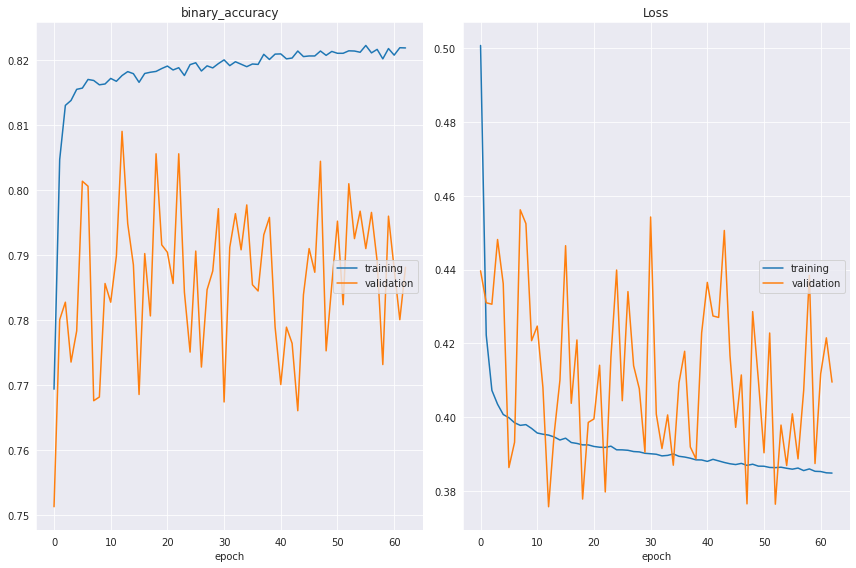

binary_accuracy
	training         	 (min:    0.769, max:    0.822, cur:    0.822)
	validation       	 (min:    0.751, max:    0.809, cur:    0.788)
Loss
	training         	 (min:    0.385, max:    0.501, cur:    0.385)
	validation       	 (min:    0.376, max:    0.456, cur:    0.409)


In [46]:
with tf.device('/CPU:0'):

    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_adult = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_adult.fit(X_train_adult,
                                      y_train_adult, 
                                      epochs=config['lambda_net']['epochs_lambda'], 
                                      batch_size=config['lambda_net']['batch_lambda'], 
                                      callbacks=[early_stopping, PlotLossesKerasTF()],
                                      validation_data=(X_valid_adult, y_valid_adult),
                                      verbose=0)



In [47]:
test_network_adult.summary()

Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_504 (Dense)            (None, 128)               1280      
_________________________________________________________________
dense_505 (Dense)            (None, 1)                 129       
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [48]:
test_network_adult_parameters = shaped_network_parameters_to_array(test_network_adult.get_weights(), config)

start_inet = time.time() 

network_parameters = np.array([test_network_adult_parameters])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
test_network_adult_dt_inet = model.predict(network_parameters)[0]    

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [49]:
dataset_size_list = [1_000, 10_000, 100_000, 1_000_000, 'TRAIN_DATA']
    
results_adult_list = []
dt_distilled_adult_list = []
for dataset_size in dataset_size_list:
    
    if dataset_size == 'TRAIN_DATA': 
        results_adult, dt_distilled_adult = evaluate_interpretation_net_prediction_single_sample(test_network_adult_parameters, 
                                                                           test_network_adult_dt_inet,
                                                                           X_test_adult.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_adult.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_adult, dt_distilled_adult = evaluate_interpretation_net_prediction_single_sample(test_network_adult_parameters, 
                                                                           test_network_adult_dt_inet,
                                                                           X_test_adult.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_adult['inet_scores']['runtime'] = inet_runtime
    results_adult_list.append(results_adult)
    dt_distilled_adult_list.append(dt_distilled_adult)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_adult['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_adult['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_adult['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy',  np.round(results_adult['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_adult['dt_scores']['binary_crossentropy'], 3), np.round(results_adult['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_adult['dt_scores']['accuracy_data_random'], 3), np.round(results_adult['dt_scores']['accuracy'], 3), np.round(results_adult['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_adult['dt_scores']['f1_score_data_random'], 3), np.round(results_adult['dt_scores']['f1_score'], 3), np.round(results_adult['inet_scores']['f1_score'], 3)],
            ['Runtime',  np.round(results_adult['dt_scores']['runtime'], 3), np.round(results_adult['dt_scores']['runtime'], 3), np.round(results_adult['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             
        
adult_evaluation_result_dict = None
for some_dict in results_adult_list:
    if adult_evaluation_result_dict == None:
        adult_evaluation_result_dict = some_dict
    else:
        adult_evaluation_result_dict = mergeDict(adult_evaluation_result_dict, some_dict)

#adult_evaluation_result_dict['dataset_size'] = dataset_size_list
                

Dataset Size:		 1000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.334               |          0.674           |        0.723         |
|   Binary Crossentropy    |              0.024               |          10.051          |        0.763         |
|         Accuracy         |              0.993               |          0.595           |        0.379         |
|         F1 Score         |              0.996               |          0.313           |         0.55         |
|         Runtime          |              0.004               |          0.004           |        0.173         |
+--------------------------+----------------------------------+----

In [50]:
print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = flatten_list(['Metric', [['Dist. (Random) ' + str(size), 'Dist. ' + str(size)] for size in dataset_size_list], 'I-Net'])
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft Binary Crossentropy', 
                      [[np.round(result_dict['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['soft_binary_crossentropy'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['soft_binary_crossentropy'], 3)]),
        flatten_list(['Binary Crossentropy',  
                      [[np.round(result_dict['dt_scores']['binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['binary_crossentropy'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['binary_crossentropy'], 3)]),
        flatten_list(['Accuracy', 
                      [[np.round(result_dict['dt_scores']['accuracy_data_random'], 3), np.round(result_dict['dt_scores']['accuracy'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['accuracy'], 3)]),
        flatten_list(['F1 Score', 
                      [[np.round(result_dict['dt_scores']['f1_score_data_random'], 3), np.round(result_dict['dt_scores']['f1_score'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['f1_score'], 3)]),
        flatten_list(['Runtime',  
                      [[np.round(result_dict['dt_scores']['runtime'], 3), np.round(result_dict['dt_scores']['runtime'], 3)] for result_dict in results_adult_list],
                      np.round(results_adult['inet_scores']['runtime'], 3)])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


Dataset Size:		 TRAIN_DATA
+--------------------------+---------------------+------------+----------------------+-------------+-----------------------+--------------+------------------------+---------------+---------------------------+------------------+-------+
|          Metric          | Dist. (Random) 1000 | Dist. 1000 | Dist. (Random) 10000 | Dist. 10000 | Dist. (Random) 100000 | Dist. 100000 | Dist. (Random) 1000000 | Dist. 1000000 | Dist. (Random) TRAIN_DATA | Dist. TRAIN_DATA | I-Net |
+--------------------------+---------------------+------------+----------------------+-------------+-----------------------+--------------+------------------------+---------------+---------------------------+------------------+-------+
| Soft Binary Crossentropy |        0.334        |   0.674    |        0.341         |    0.827    |         0.342         |    0.814     |         0.342          |     0.834     |           0.516           |      0.509       | 0.723 |
|   Binary Crossentropy    | 

In [51]:
(z_score_aggregate_adult, 
 distance_to_initialization_aggregate_adult, 
 distance_to_sample_average_adult, 
 distance_to_sample_min_adult,
 max_distance_to_neuron_average_adult,
 max_distance_to_neuron_min_adult) = calculate_network_distance(mean=mean_train, 
                                                       std=std_train, 
                                                       network_parameters=test_network_adult_parameters, 
                                                       lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                       config=config)

In [52]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data', 'Adult Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3), np.round(z_score_aggregate_adult, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3), np.round(distance_to_initialization_aggregate_adult, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3), np.round(distance_to_sample_average_adult, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3), np.round(distance_to_sample_min_adult, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3), np.round(max_distance_to_neuron_average_adult, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3), np.round(max_distance_to_neuron_min_adult, 3)],           
    ]    
)
print(tab)

+-----------------------------------------------+------------+------------+-----------+------------+
|                    Measure                    | Train Data | Valid Data | Test Data | Adult Data |
+-----------------------------------------------+------------+------------+-----------+------------+
|     Average Z-Score (Sample to Train Data)    |  847.099   |  872.469   |  878.767  |  1494.727  |
|       Average Distance to Initialization      |  294.878   |   306.25   |  310.315  |  386.864   |
|      Average Mean Distance to Train Data      |  408.213   |  415.178   |  418.985  |  520.943   |
| Average Distance to closest Train Data Sample |    0.0     |  252.035   |  260.938  |  359.998   |
|   Average Biggest Distance for Single Neuron  |   4.289    |   4.391    |   4.423   |   10.341   |
|   Minimum Biggest Distance for Single Neuron  |    0.0     |   2.499    |   2.551   |    8.86    |
+-----------------------------------------------+------------+------------+-----------+----

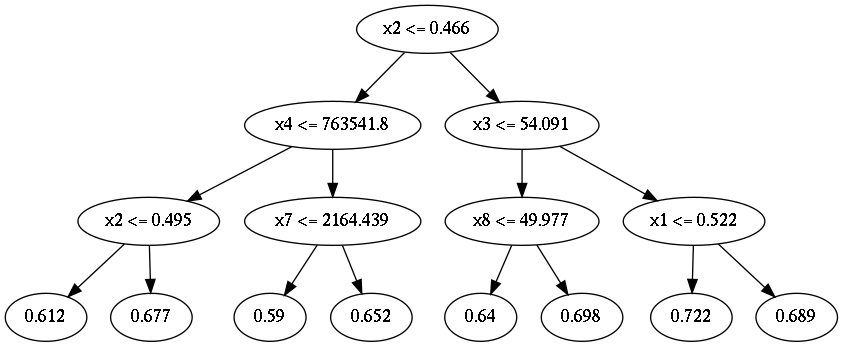

In [53]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_adult_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_adult_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

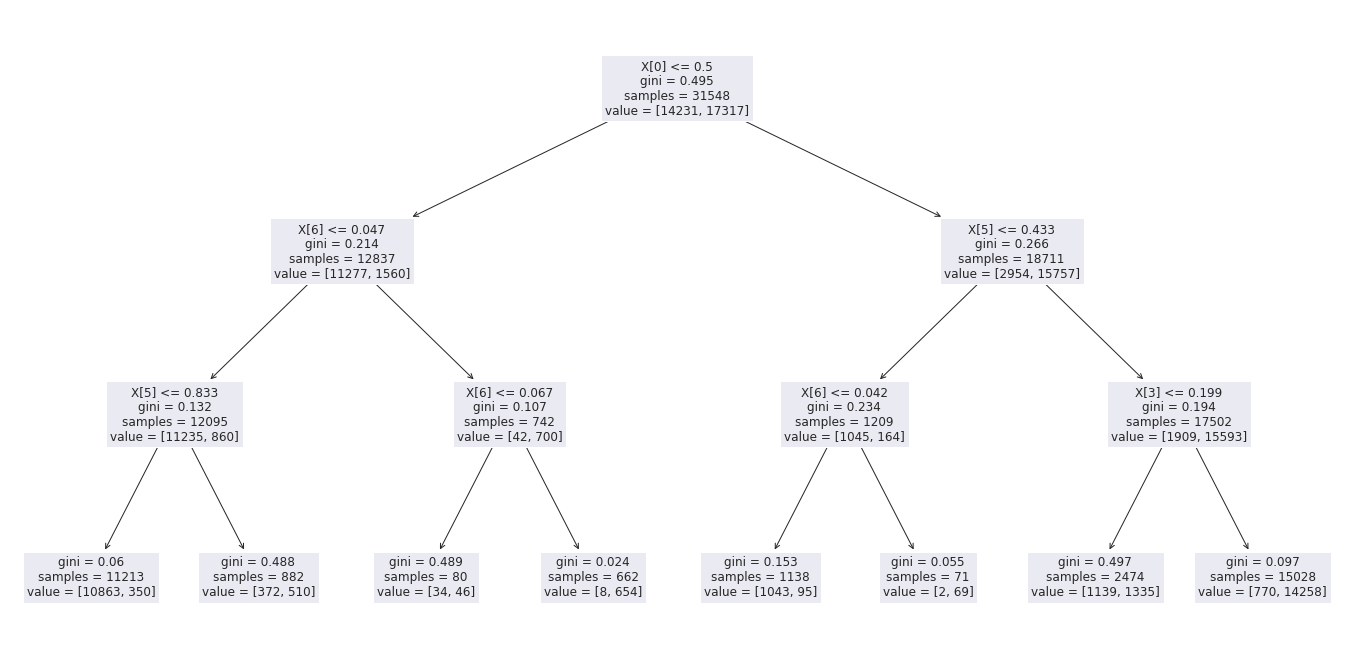

In [54]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_adult, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_adult.plot_tree()
image

## Titanic Dataset

In [55]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [56]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [57]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [58]:
titanic_data = titanic_data.drop([
                                    'Cabin', 
                                    'Ticket', 
                                    'Name', 
                                    'PassengerId'
                                ], axis = 1)


In [59]:
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [60]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000,1,0,7.250,S
1,1,1,female,38.000,1,0,71.283,C
2,1,3,female,26.000,0,0,7.925,S
3,1,1,female,35.000,1,0,53.100,S
4,0,3,male,35.000,0,0,8.050,S


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [61]:
features_select = [
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

categorical_features = ['Embarked']#[1, 2, 7]
ordinal_features = ['Sex']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(titanic_data)

titanic_data = transformer.transform(titanic_data)
titanic_data = pd.DataFrame(titanic_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    titanic_data[ordinal_feature] = OrdinalEncoder().fit_transform(titanic_data[ordinal_feature].values.reshape(-1, 1)).flatten()

titanic_data = titanic_data.astype(np.float64)

    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']

print(X_data_titanic.shape)
X_data_titanic.head()

(891, 9)


,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare
0,0.000,0.000,1.000,1.000,3.000,22.000,1.000,0.000,7.250
1,1.000,0.000,0.000,0.000,1.000,38.000,1.000,0.000,71.283
2,0.000,0.000,1.000,0.000,3.000,26.000,0.000,0.000,7.925
3,0.000,0.000,1.000,0.000,1.000,35.000,1.000,0.000,53.100
4,0.000,0.000,1.000,1.000,3.000,35.000,0.000,0.000,8.050


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [62]:
if X_data_titanic.shape[1] > number_of_variables:
    #X_data_titanic = X_data_titanic.sample(n=number_of_variables,axis='columns')
    
    clf_titanic = ExtraTreesClassifier(n_estimators=100,
                                      random_state=RANDOM_SEED)
    clf_titanic = clf_titanic.fit(X_data_titanic, y_data_titanic)

    selector_titanic = SelectFromModel(clf_titanic, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_titanic.get_support()   
    X_data_titanic = X_data_titanic.loc[:,feature_idx]    
else:
    for i in range(number_of_variables-X_data_titanic.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_titanic[column_name] = np.zeros(X_data_titanic.shape[0])
X_data_titanic.head()

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare
0,0.000,0.000,1.000,1.000,3.000,22.000,1.000,0.000,7.250
1,1.000,0.000,0.000,0.000,1.000,38.000,1.000,0.000,71.283
2,0.000,0.000,1.000,0.000,3.000,26.000,0.000,0.000,7.925
3,0.000,0.000,1.000,0.000,1.000,35.000,1.000,0.000,53.100
4,0.000,0.000,1.000,1.000,3.000,35.000,0.000,0.000,8.050


In [63]:
normalizer_list = []
for column_name in X_data_titanic:
    scaler = MinMaxScaler()
    scaler.fit(X_data_titanic[column_name].values.reshape(-1, 1))
    X_data_titanic[column_name] = scaler.transform(X_data_titanic[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_titanic.head()

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare
0,0.000,0.000,1.000,1.000,1.000,0.271,0.125,0.000,0.014
1,1.000,0.000,0.000,0.000,0.000,0.472,0.125,0.000,0.139
2,0.000,0.000,1.000,0.000,1.000,0.321,0.000,0.000,0.015
3,0.000,0.000,1.000,0.000,0.000,0.435,0.125,0.000,0.104
4,0.000,0.000,1.000,1.000,1.000,0.435,0.000,0.000,0.016


In [64]:
y_data_titanic

0     0.000
1     1.000
2     1.000
3     1.000
4     0.000
       ... 
886   0.000
887   1.000
888   0.000
889   1.000
890   0.000
Name: Survived, Length: 891, dtype: float64

In [65]:
X_train_titanic_with_valid, X_test_titanic, y_train_titanic_with_valid, y_test_titanic = train_test_split(X_data_titanic, y_data_titanic, train_size=0.8, random_state=RANDOM_SEED)
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X_train_titanic_with_valid, y_train_titanic_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_titanic.shape, y_train_titanic.shape)
print(X_valid_titanic.shape, y_valid_titanic.shape)
print(X_test_titanic.shape, y_test_titanic.shape)

(569, 9) (569,)
(143, 9) (143,)
(179, 9) (179,)


In [66]:
true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

True Ratio:  0.37258347978910367


In [67]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_titanic, y_train_titanic = oversample.fit_resample(X_train_titanic, y_train_titanic)

    true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
    false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

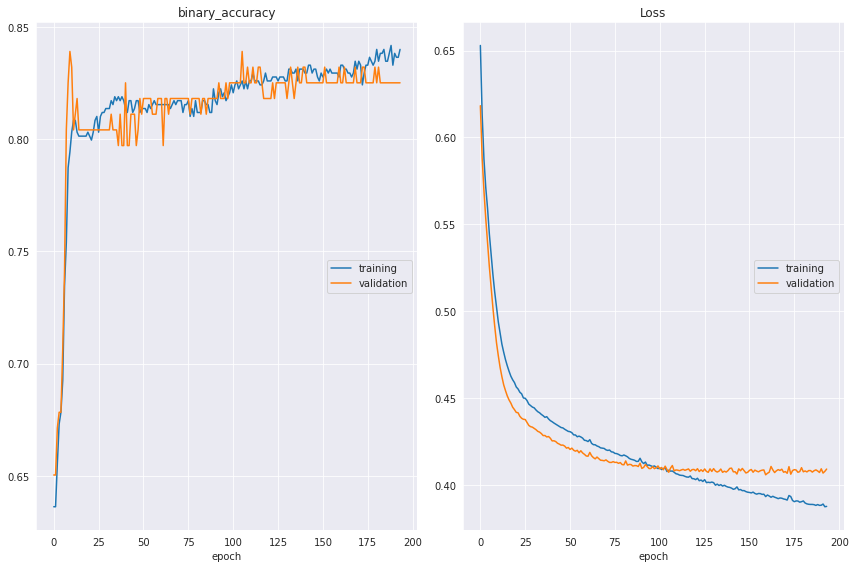

binary_accuracy
	training         	 (min:    0.636, max:    0.842, cur:    0.840)
	validation       	 (min:    0.650, max:    0.839, cur:    0.825)
Loss
	training         	 (min:    0.388, max:    0.653, cur:    0.388)
	validation       	 (min:    0.406, max:    0.618, cur:    0.409)


In [68]:
with tf.device('/CPU:0'):

    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_titanic = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_titanic.fit(X_train_titanic,
                                          y_train_titanic, 
                                          epochs=config['lambda_net']['epochs_lambda'], 
                                          batch_size=config['lambda_net']['batch_lambda'], 
                                          callbacks=[early_stopping, PlotLossesKerasTF()],
                                          validation_data=(X_valid_titanic, y_valid_titanic),
                                          verbose=0)



In [69]:
test_network_titanic.summary()

Model: "sequential_259"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_518 (Dense)            (None, 128)               1280      
_________________________________________________________________
dense_519 (Dense)            (None, 1)                 129       
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [70]:
test_network_titanic_parameters = shaped_network_parameters_to_array(test_network_titanic.get_weights(), config)

start_inet = time.time() 

network_parameters = np.array([test_network_titanic_parameters])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
test_network_titanic_dt_inet = model.predict(network_parameters)[0]    

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [71]:
results_titanic_list = []
dt_distilled_titanic_list = []
for dataset_size in dataset_size_list:
    
    if dataset_size == 'TRAIN_DATA': 
        results_titanic, dt_distilled_titanic = evaluate_interpretation_net_prediction_single_sample(test_network_titanic_parameters, 
                                                                           test_network_titanic_dt_inet,
                                                                           X_test_titanic.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_titanic.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_titanic, dt_distilled_titanic = evaluate_interpretation_net_prediction_single_sample(test_network_titanic_parameters, 
                                                                           test_network_titanic_dt_inet,
                                                                           X_test_titanic.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_titanic['inet_scores']['runtime'] = inet_runtime
    results_titanic_list.append(results_titanic)
    dt_distilled_titanic_list.append(dt_distilled_titanic)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_titanic['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_titanic['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_titanic['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy', np.round(results_titanic['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_titanic['dt_scores']['binary_crossentropy'], 3), np.round(results_titanic['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_titanic['dt_scores']['accuracy_data_random'], 3), np.round(results_titanic['dt_scores']['accuracy'], 3), np.round(results_titanic['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_titanic['dt_scores']['f1_score_data_random'], 3), np.round(results_titanic['dt_scores']['f1_score'], 3), np.round(results_titanic['inet_scores']['f1_score'], 3)],
            ['Runtime',  np.round(results_titanic['dt_scores']['runtime'], 3), np.round(results_titanic['dt_scores']['runtime'], 3), np.round(results_titanic['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')        
        
titanic_evaluation_result_dict = None
for some_dict in results_titanic_list:
    if titanic_evaluation_result_dict == None:
        titanic_evaluation_result_dict = some_dict
    else:
        titanic_evaluation_result_dict = mergeDict(titanic_evaluation_result_dict, some_dict)

#titanic_evaluation_result_dict['dataset_size'] = dataset_size_list
                

Dataset Size:		 1000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.591               |          0.589           |        0.589         |
|   Binary Crossentropy    |              0.432               |          0.586           |        0.401         |
|         Accuracy         |               0.8                |          0.765           |        0.933         |
|         F1 Score         |              0.822               |          0.753           |        0.912         |
|         Runtime          |              0.004               |          0.004           |        0.126         |
+--------------------------+----------------------------------+----

In [72]:
print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = flatten_list(['Metric', [['Dist. (Random) ' + str(size), 'Dist. ' + str(size)] for size in dataset_size_list], 'I-Net'])
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft Binary Crossentropy', 
                      [[np.round(result_dict['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['soft_binary_crossentropy'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['soft_binary_crossentropy'], 3)]),
        flatten_list(['Binary Crossentropy',  
                      [[np.round(result_dict['dt_scores']['binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['binary_crossentropy'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['binary_crossentropy'], 3)]),
        flatten_list(['Accuracy', 
                      [[np.round(result_dict['dt_scores']['accuracy_data_random'], 3), np.round(result_dict['dt_scores']['accuracy'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['accuracy'], 3)]),
        flatten_list(['F1 Score', 
                      [[np.round(result_dict['dt_scores']['f1_score_data_random'], 3), np.round(result_dict['dt_scores']['f1_score'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['f1_score'], 3)]),
        flatten_list(['Runtime',  
                      [[np.round(result_dict['dt_scores']['runtime'], 3), np.round(result_dict['dt_scores']['runtime'], 3)] for result_dict in results_titanic_list],
                      np.round(results_titanic['inet_scores']['runtime'], 3)])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


Dataset Size:		 TRAIN_DATA
+--------------------------+---------------------+------------+----------------------+-------------+-----------------------+--------------+------------------------+---------------+---------------------------+------------------+-------+
|          Metric          | Dist. (Random) 1000 | Dist. 1000 | Dist. (Random) 10000 | Dist. 10000 | Dist. (Random) 100000 | Dist. 100000 | Dist. (Random) 1000000 | Dist. 1000000 | Dist. (Random) TRAIN_DATA | Dist. TRAIN_DATA | I-Net |
+--------------------------+---------------------+------------+----------------------+-------------+-----------------------+--------------+------------------------+---------------+---------------------------+------------------+-------+
| Soft Binary Crossentropy |        0.591        |   0.589    |        0.597         |    0.555    |         0.603         |    0.564     |         0.604          |     0.563     |           0.501           |      0.501       | 0.589 |
|   Binary Crossentropy    | 

In [73]:
(z_score_aggregate_titanic, 
 distance_to_initialization_aggregate_titanic, 
 distance_to_sample_average_titanic, 
 distance_to_sample_min_titanic,
 max_distance_to_neuron_average_titanic,
 max_distance_to_neuron_min_titanic) = calculate_network_distance(mean=mean_train, 
                                                       std=std_train, 
                                                       network_parameters=test_network_titanic_parameters, 
                                                       lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                       config=config)

In [74]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data', 'Adult Data', 'Titanic Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3), np.round(z_score_aggregate_adult, 3), np.round(z_score_aggregate_titanic, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3), np.round(distance_to_initialization_aggregate_adult, 3), np.round(distance_to_initialization_aggregate_titanic, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3), np.round(distance_to_sample_average_adult, 3), np.round(distance_to_sample_average_titanic, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3), np.round(distance_to_sample_min_adult, 3), np.round(distance_to_sample_min_titanic, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3), np.round(max_distance_to_neuron_average_adult, 3), np.round(max_distance_to_neuron_average_titanic, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3), np.round(max_distance_to_neuron_min_adult, 3), np.round(max_distance_to_neuron_min_titanic, 3)],           
    ]    
)
print(tab)

+-----------------------------------------------+------------+------------+-----------+------------+--------------+
|                    Measure                    | Train Data | Valid Data | Test Data | Adult Data | Titanic Data |
+-----------------------------------------------+------------+------------+-----------+------------+--------------+
|     Average Z-Score (Sample to Train Data)    |  847.099   |  872.469   |  878.767  |  1494.727  |   690.165    |
|       Average Distance to Initialization      |  294.878   |   306.25   |  310.315  |  386.864   |   175.446    |
|      Average Mean Distance to Train Data      |  408.213   |  415.178   |  418.985  |  520.943   |   353.829    |
| Average Distance to closest Train Data Sample |    0.0     |  252.035   |  260.938  |  359.998   |   177.254    |
|   Average Biggest Distance for Single Neuron  |   4.289    |   4.391    |   4.423   |   10.341   |    3.382     |
|   Minimum Biggest Distance for Single Neuron  |    0.0     |   2.499  

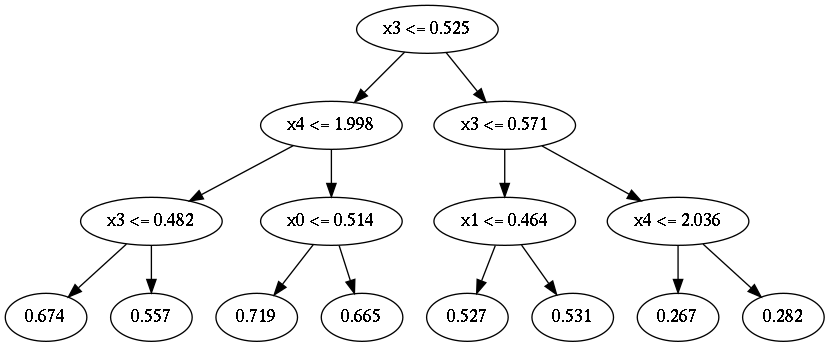

In [75]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_titanic_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_titanic_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

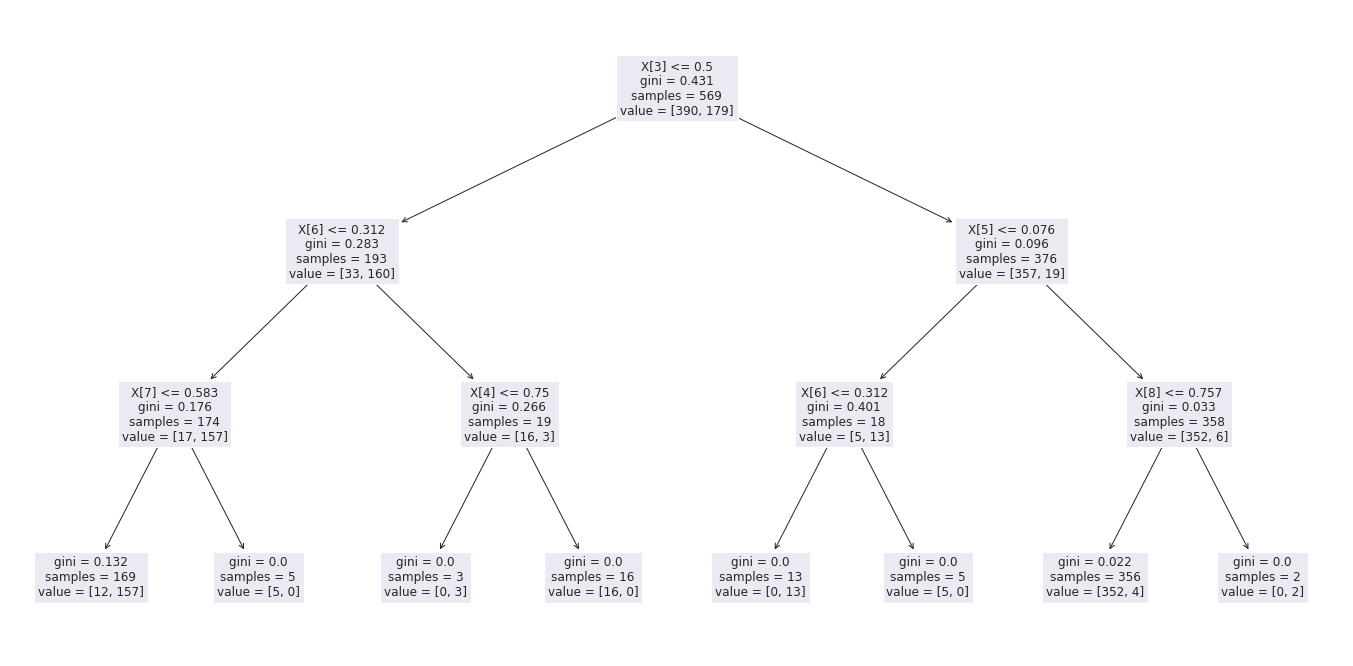

In [76]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_titanic, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_titanic.plot_tree()
image

## Absenteeism at Work Dataset

In [77]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

absenteeism_data.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [78]:
absenteeism_data.describe()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000
mean,18.018,19.216,6.324,3.915,2.545,221.330,29.631,12.554,36.450,271.490,94.588,0.054,1.292,1.019,0.568,0.073,0.746,79.035,172.115,26.677,6.924
std,11.021,8.433,3.436,1.422,1.112,66.952,14.837,4.385,6.479,39.058,3.779,0.226,0.673,1.098,0.496,0.260,1.318,12.883,6.035,4.285,13.331
min,1.000,0.000,0.000,2.000,1.000,118.000,5.000,1.000,27.000,205.917,81.000,0.000,1.000,0.000,0.000,0.000,0.000,56.000,163.000,19.000,0.000
25%,9.000,13.000,3.000,3.000,2.000,179.000,16.000,9.000,31.000,244.387,93.000,0.000,1.000,0.000,0.000,0.000,0.000,69.000,169.000,24.000,2.000
50%,18.000,23.000,6.000,4.000,3.000,225.000,26.000,13.000,37.000,264.249,95.000,0.000,1.000,1.000,1.000,0.000,0.000,83.000,170.000,25.000,3.000
75%,28.000,26.000,9.000,5.000,4.000,260.000,50.000,16.000,40.000,294.217,97.000,0.000,1.000,2.000,1.000,0.000,1.000,89.000,172.000,31.000,8.000
max,36.000,28.000,12.000,6.000,4.000,388.000,52.000,29.000,58.000,378.884,100.000,1.000,4.000,4.000,1.000,1.000,8.000,108.000,196.000,38.000,120.000


In [79]:
absenteeism_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [80]:
absenteeism_data.isnull().sum()

ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

In [81]:
features_select = [
                           'Disciplinary failure', #CATEGORICAL
                           'Social drinker', #CATEGORICAL
                           'Social smoker', #CATEGORICAL
                           'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           'Hit target',
                           'Education', 
                           'Son', 
                           'Pet', 
                           'Weight', 
                           'Height', 
                           'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

categorical_features = []#[1, 2, 7]
ordinal_features = []

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(absenteeism_data)

absenteeism_data = transformer.transform(absenteeism_data)
absenteeism_data = pd.DataFrame(absenteeism_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    absenteeism_data[ordinal_feature] = OrdinalEncoder().fit_transform(absenteeism_data[ordinal_feature].values.reshape(-1, 1)).flatten()

absenteeism_data = absenteeism_data.astype(np.float64)

    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 4) * 1) #absenteeism_data['Absenteeism time in hours']

print(X_data_absenteeism.shape)
X_data_absenteeism.head()

(740, 15)


,Disciplinary failure,Social drinker,Social smoker,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Education,Son,Pet,Weight,Height,Body mass index
0,0.000,1.000,0.000,289.000,36.000,13.000,33.000,239.554,97.000,1.000,2.000,1.000,90.000,172.000,30.000
1,1.000,1.000,0.000,118.000,13.000,18.000,50.000,239.554,97.000,1.000,1.000,0.000,98.000,178.000,31.000
2,0.000,1.000,0.000,179.000,51.000,18.000,38.000,239.554,97.000,1.000,0.000,0.000,89.000,170.000,31.000
3,0.000,1.000,1.000,279.000,5.000,14.000,39.000,239.554,97.000,1.000,2.000,0.000,68.000,168.000,24.000
4,0.000,1.000,0.000,289.000,36.000,13.000,33.000,239.554,97.000,1.000,2.000,1.000,90.000,172.000,30.000


    3. Month of absence
    4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
    5. Seasons (summer (1), autumn (2), winter (3), spring (4))
    6. Transportation expense
    7. Distance from Residence to Work (kilometers)
    8. Service time
    9. Age
    10. Work load Average/day
    11. Hit target
    12. Disciplinary failure (yes=1; no=0)
    13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
    14. Son (number of children)
    15. Social drinker (yes=1; no=0)
    16. Social smoker (yes=1; no=0)
    17. Pet (number of pet)
    18. Weight
    19. Height
    20. Body mass index
    21. Absenteeism time in hours (target)

In [82]:
if X_data_absenteeism.shape[1] > number_of_variables:
    #X_data_absenteeism = X_data_absenteeism.sample(n=number_of_variables,axis='columns')
    
    clf_absenteeism = ExtraTreesClassifier(n_estimators=100,
                                          random_state=RANDOM_SEED)
    clf_absenteeism = clf_absenteeism.fit(X_data_absenteeism, y_data_absenteeism)

    selector_absenteeism = SelectFromModel(clf_absenteeism, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_absenteeism.get_support()   
    X_data_absenteeism = X_data_absenteeism.loc[:,feature_idx]        
else:
    for i in range(number_of_variables-X_data_absenteeism.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_absenteeism[column_name] = np.zeros(X_data_absenteeism.shape[0])
X_data_absenteeism.head()

,Disciplinary failure,Transportation expense,Service time,Age,Work load Average/day,Hit target,Son,Height,Body mass index
0,0.000,289.000,13.000,33.000,239.554,97.000,2.000,172.000,30.000
1,1.000,118.000,18.000,50.000,239.554,97.000,1.000,178.000,31.000
2,0.000,179.000,18.000,38.000,239.554,97.000,0.000,170.000,31.000
3,0.000,279.000,14.000,39.000,239.554,97.000,2.000,168.000,24.000
4,0.000,289.000,13.000,33.000,239.554,97.000,2.000,172.000,30.000


In [83]:
normalizer_list = []
for column_name in X_data_absenteeism:
    scaler = MinMaxScaler()
    scaler.fit(X_data_absenteeism[column_name].values.reshape(-1, 1))
    X_data_absenteeism[column_name] = scaler.transform(X_data_absenteeism[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_absenteeism.head()

,Disciplinary failure,Transportation expense,Service time,Age,Work load Average/day,Hit target,Son,Height,Body mass index
0,0.000,0.633,0.429,0.194,0.194,0.842,0.500,0.273,0.579
1,1.000,0.000,0.607,0.742,0.194,0.842,0.250,0.455,0.632
2,0.000,0.226,0.607,0.355,0.194,0.842,0.000,0.212,0.632
3,0.000,0.596,0.464,0.387,0.194,0.842,0.500,0.152,0.263
4,0.000,0.633,0.429,0.194,0.194,0.842,0.500,0.273,0.579


In [84]:
y_data_absenteeism

0      0
1      0
2      0
3      0
4      0
      ..
735    1
736    0
737    0
738    0
739    0
Name: Absenteeism time in hours, Length: 740, dtype: int64

In [85]:
X_train_absenteeism_with_valid, X_test_absenteeism, y_train_absenteeism_with_valid, y_test_absenteeism = train_test_split(X_data_absenteeism, y_data_absenteeism, train_size=0.8, random_state=RANDOM_SEED)
X_train_absenteeism, X_valid_absenteeism, y_train_absenteeism, y_valid_absenteeism = train_test_split(X_train_absenteeism_with_valid, y_train_absenteeism_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_absenteeism.shape, y_train_absenteeism.shape)
print(X_valid_absenteeism.shape, y_valid_absenteeism.shape)
print(X_test_absenteeism.shape, y_test_absenteeism.shape)

(473, 9) (473,)
(119, 9) (119,)
(148, 9) (148,)


In [86]:
true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

True Ratio:  0.38054968287526425


In [87]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_absenteeism, y_train_absenteeism = oversample.fit_resample(X_train_absenteeism, y_train_absenteeism)

    true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
    false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

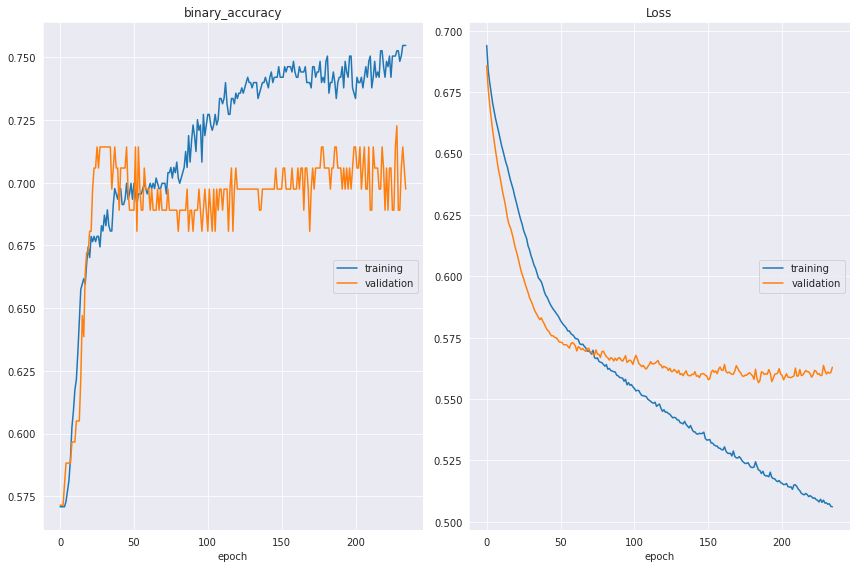

binary_accuracy
	training         	 (min:    0.571, max:    0.755, cur:    0.755)
	validation       	 (min:    0.571, max:    0.723, cur:    0.697)
Loss
	training         	 (min:    0.506, max:    0.694, cur:    0.506)
	validation       	 (min:    0.557, max:    0.686, cur:    0.563)


In [88]:
with tf.device('/CPU:0'):
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_absenteeism = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_absenteeism.fit(X_train_absenteeism,
                                      y_train_absenteeism, 
                                      epochs=config['lambda_net']['epochs_lambda'], 
                                      batch_size=config['lambda_net']['batch_lambda'], 
                                      callbacks=[early_stopping, PlotLossesKerasTF()],
                                      validation_data=(X_valid_absenteeism, y_valid_absenteeism),
                                      verbose=0)



In [89]:
test_network_absenteeism.summary()

Model: "sequential_266"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_532 (Dense)            (None, 128)               1280      
_________________________________________________________________
dense_533 (Dense)            (None, 1)                 129       
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________


In [90]:
test_network_absenteeism_parameters = shaped_network_parameters_to_array(test_network_absenteeism.get_weights(), config)

start_inet = time.time() 

network_parameters = np.array([test_network_absenteeism_parameters])
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data([network_parameters], config, encoder_model)    
test_network_absenteeism_dt_inet = model.predict(network_parameters)[0]  

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [91]:
results_absenteeism_list = []
dt_distilled_absenteeism_list = []
for dataset_size in dataset_size_list:
    
    if dataset_size == 'TRAIN_DATA': 
        results_absenteeism, dt_distilled_absenteeism = evaluate_interpretation_net_prediction_single_sample(test_network_absenteeism_parameters, 
                                                                           test_network_absenteeism_dt_inet,
                                                                           X_test_absenteeism.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_absenteeism.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_absenteeism, dt_distilled_absenteeism = evaluate_interpretation_net_prediction_single_sample(test_network_absenteeism_parameters, 
                                                                           test_network_absenteeism_dt_inet,
                                                                           X_test_absenteeism.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_absenteeism['inet_scores']['runtime'] = inet_runtime
    results_absenteeism_list.append(results_absenteeism)
    dt_distilled_absenteeism_list.append(dt_distilled_absenteeism)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_absenteeism['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_absenteeism['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_absenteeism['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy', np.round(results_absenteeism['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_absenteeism['dt_scores']['binary_crossentropy'], 3), np.round(results_absenteeism['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_absenteeism['dt_scores']['accuracy_data_random'], 3), np.round(results_absenteeism['dt_scores']['accuracy'], 3), np.round(results_absenteeism['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_absenteeism['dt_scores']['f1_score_data_random'], 3), np.round(results_absenteeism['dt_scores']['f1_score'], 3), np.round(results_absenteeism['inet_scores']['f1_score'], 3)],
            ['Runtime', np.round(results_absenteeism['dt_scores']['runtime'], 3), np.round(results_absenteeism['dt_scores']['runtime'], 3), np.round(results_absenteeism['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')        

    
absenteeism_evaluation_result_dict = None
for some_dict in results_absenteeism_list:
    if absenteeism_evaluation_result_dict == None:
        absenteeism_evaluation_result_dict = some_dict
    else:
        absenteeism_evaluation_result_dict = mergeDict(absenteeism_evaluation_result_dict, some_dict)

#absenteeism_evaluation_result_dict['dataset_size'] = dataset_size_list
                

Dataset Size:		 1000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.436               |          0.625           |        0.667         |
|   Binary Crossentropy    |              0.156               |          0.473           |        0.583         |
|         Accuracy         |               0.93               |          0.851           |         0.73         |
|         F1 Score         |              0.739               |          0.711           |         0.0          |
|         Runtime          |              0.004               |          0.004           |        0.136         |
+--------------------------+----------------------------------+----

In [92]:
print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = flatten_list(['Metric', [['Dist. (Random) ' + str(size), 'Dist. ' + str(size)] for size in dataset_size_list], 'I-Net'])
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft Binary Crossentropy', 
                      [[np.round(result_dict['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['soft_binary_crossentropy'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['soft_binary_crossentropy'], 3)]),
        flatten_list(['Binary Crossentropy',  
                      [[np.round(result_dict['dt_scores']['binary_crossentropy_data_random'], 3), np.round(result_dict['dt_scores']['binary_crossentropy'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['binary_crossentropy'], 3)]),
        flatten_list(['Accuracy', 
                      [[np.round(result_dict['dt_scores']['accuracy_data_random'], 3), np.round(result_dict['dt_scores']['accuracy'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['accuracy'], 3)]),
        flatten_list(['F1 Score', 
                      [[np.round(result_dict['dt_scores']['f1_score_data_random'], 3), np.round(result_dict['dt_scores']['f1_score'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['f1_score'], 3)]),
        flatten_list(['Runtime',  
                      [[np.round(result_dict['dt_scores']['runtime'], 3), np.round(result_dict['dt_scores']['runtime'], 3)] for result_dict in results_absenteeism_list],
                      np.round(results_titanic['inet_scores']['runtime'], 3)])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


Dataset Size:		 TRAIN_DATA
+--------------------------+---------------------+------------+----------------------+-------------+-----------------------+--------------+------------------------+---------------+---------------------------+------------------+-------+
|          Metric          | Dist. (Random) 1000 | Dist. 1000 | Dist. (Random) 10000 | Dist. 10000 | Dist. (Random) 100000 | Dist. 100000 | Dist. (Random) 1000000 | Dist. 1000000 | Dist. (Random) TRAIN_DATA | Dist. TRAIN_DATA | I-Net |
+--------------------------+---------------------+------------+----------------------+-------------+-----------------------+--------------+------------------------+---------------+---------------------------+------------------+-------+
| Soft Binary Crossentropy |        0.436        |   0.625    |        0.441         |    0.637    |         0.444         |    0.621     |         0.444          |     0.631     |           0.605           |      0.606       | 0.589 |
|   Binary Crossentropy    | 

In [93]:
(z_score_aggregate_absenteeism, 
 distance_to_initialization_aggregate_absenteeism, 
 distance_to_sample_average_absenteeism, 
 distance_to_sample_min_absenteeism,
 max_distance_to_neuron_average_absenteeism,
 max_distance_to_neuron_min_absenteeism) = calculate_network_distance(mean=mean_train, 
                                                       std=std_train, 
                                                       network_parameters=test_network_absenteeism_parameters, 
                                                       lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array, 
                                                       config=config)

In [94]:
tab = PrettyTable()
tab.field_names = ['Measure', 'Train Data', 'Valid Data', 'Test Data', 'Adult Data', 'Titanic Data', 'Absenteeism Data']
tab.add_rows(
    [
        ['Average Z-Score (Sample to Train Data)', np.round(z_score_average_train, 3), np.round(z_score_average_valid, 3), np.round(z_score_average_test, 3), np.round(z_score_aggregate_adult, 3), np.round(z_score_aggregate_titanic, 3), np.round(z_score_aggregate_absenteeism, 3)],
        ['Average Distance to Initialization', np.round(distance_to_initialization_average_train, 3), np.round(distance_to_initialization_average_valid, 3), np.round(distance_to_initialization_average_test, 3), np.round(distance_to_initialization_aggregate_adult, 3), np.round(distance_to_initialization_aggregate_titanic, 3), np.round(distance_to_initialization_aggregate_absenteeism, 3)],
        ['Average Mean Distance to Train Data', np.round(distance_to_sample_average_average_train, 3), np.round(distance_to_sample_average_average_valid, 3), np.round(distance_to_sample_average_average_test, 3), np.round(distance_to_sample_average_adult, 3), np.round(distance_to_sample_average_titanic, 3), np.round(distance_to_sample_average_absenteeism, 3)],
        ['Average Distance to closest Train Data Sample', np.round(distance_to_sample_min_average_train, 3), np.round(distance_to_sample_min_average_valid, 3), np.round(distance_to_sample_min_average_test, 3), np.round(distance_to_sample_min_adult, 3), np.round(distance_to_sample_min_titanic, 3), np.round(distance_to_sample_min_absenteeism, 3)],
        ['Average Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_average_average_train, 3), np.round(max_distance_to_neuron_average_average_valid, 3), np.round(max_distance_to_neuron_average_average_test, 3), np.round(max_distance_to_neuron_average_adult, 3), np.round(max_distance_to_neuron_average_titanic, 3), np.round(max_distance_to_neuron_average_absenteeism, 3)],
        ['Minimum Biggest Distance for Single Neuron', np.round(max_distance_to_neuron_min_average_train, 3), np.round(max_distance_to_neuron_min_average_valid, 3), np.round(max_distance_to_neuron_min_average_test, 3), np.round(max_distance_to_neuron_min_adult, 3), np.round(max_distance_to_neuron_min_titanic, 3), np.round(max_distance_to_neuron_min_absenteeism, 3)],        
    ]    
)
print(tab)

+-----------------------------------------------+------------+------------+-----------+------------+--------------+------------------+
|                    Measure                    | Train Data | Valid Data | Test Data | Adult Data | Titanic Data | Absenteeism Data |
+-----------------------------------------------+------------+------------+-----------+------------+--------------+------------------+
|     Average Z-Score (Sample to Train Data)    |  847.099   |  872.469   |  878.767  |  1494.727  |   690.165    |     548.957      |
|       Average Distance to Initialization      |  294.878   |   306.25   |  310.315  |  386.864   |   175.446    |     167.626      |
|      Average Mean Distance to Train Data      |  408.213   |  415.178   |  418.985  |  520.943   |   353.829    |     339.987      |
| Average Distance to closest Train Data Sample |    0.0     |  252.035   |  260.938  |  359.998   |   177.254    |     167.174      |
|   Average Biggest Distance for Single Neuron  |   4.2

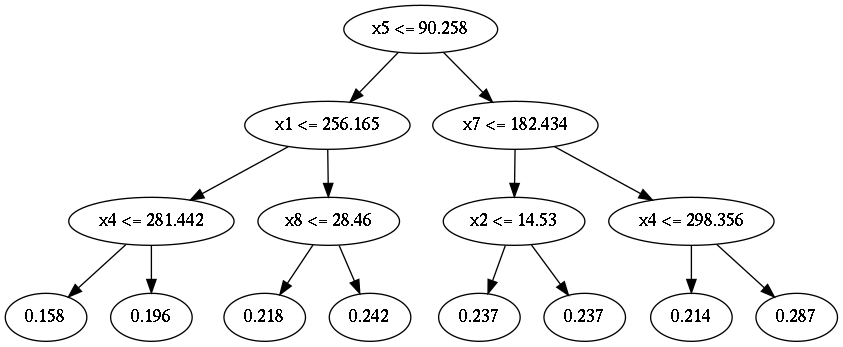

In [95]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_absenteeism_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_absenteeism_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

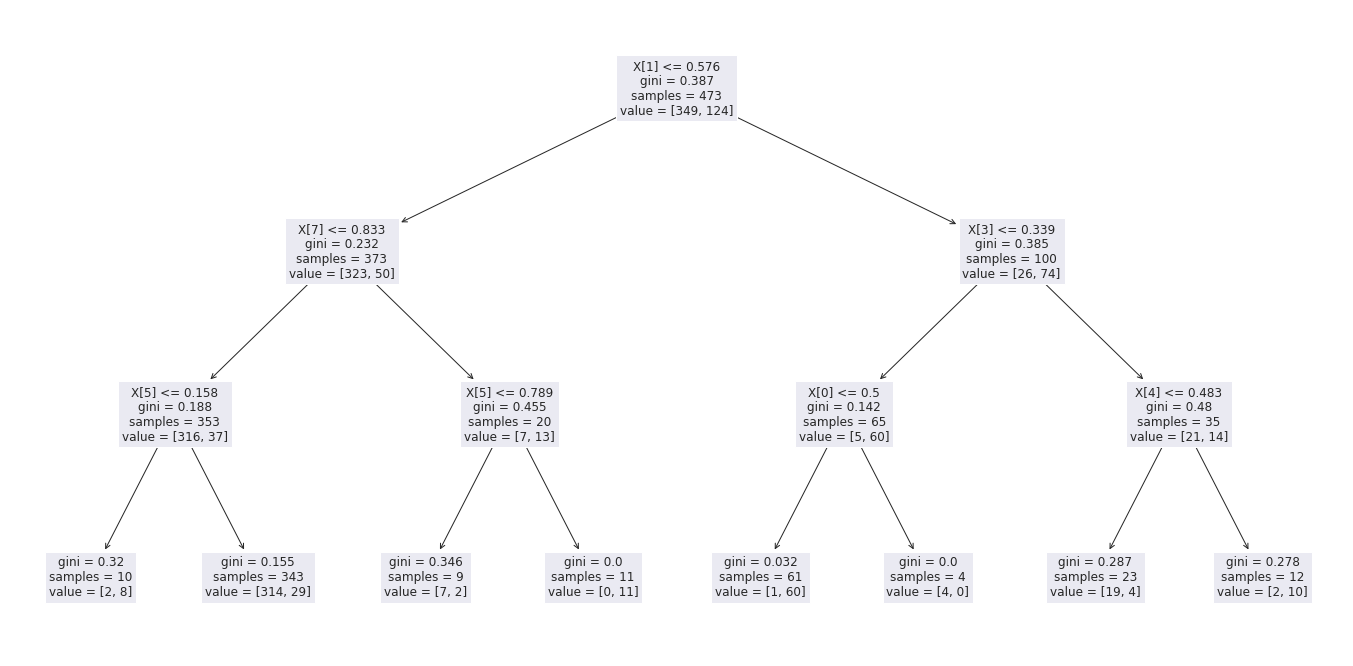

In [96]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_absenteeism, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_absenteeism.plot_tree()
image

In [98]:
dataset_size = 10000

print('Dataset Size:\t\t', dataset_size)
tab = PrettyTable()
tab.field_names = ['Metric', 
                   #'Dist. (Random) Adult', 
                   'Dist. Adult', 
                   'I-Net Adult',
                   #'Dist. (Random) Titanic', 
                   'Dist. Titanic', 
                   'I-Net Titanic',                   
                   #'Dist. (Random) Absent.', 
                   'Dist. Absent.', 
                   'I-Net Absent.',
                  ]
tab.add_rows(
    [
        #flatten_list(['Metric', [[fill('Distilled DT (Train/Random Data) ' + str(size), width=10), fill('Distilled DT (Test Data) ' + str(size), width=10)] for size in dataset_size_list_adult], fill('I-Net DT (Test Data)', width=10)]),
        flatten_list(['Soft BC', 
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3),                      
                      ]),
        flatten_list(['BC',  
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3),                       
                     ]),
        flatten_list(['Acc', 
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['accuracy'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3),      
                     ]),
        flatten_list(['F1 Score', 
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['f1_score'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3),                            
                     ]),
        flatten_list(['Runtime',  
                      #np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3), 
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3),
                      np.round(results_adult_list[dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3),                
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3), 
                      np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3),                                      
                      #np.round(results_titanic_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3), 
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3),
                      np.round(results_absenteeism_list[dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3),                            
                     ])
    ]    
)
print(tab)
print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             


Dataset Size:		 10000
+----------+-------------+-------------+---------------+---------------+---------------+---------------+
|  Metric  | Dist. Adult | I-Net Adult | Dist. Titanic | I-Net Titanic | Dist. Absent. | I-Net Absent. |
+----------+-------------+-------------+---------------+---------------+---------------+---------------+
| Soft BC  |    0.827    |    0.723    |     0.555     |     0.667     |     0.637     |     0.667     |
|    BC    |    1.412    |    0.763    |     0.359     |     0.583     |     0.524     |     0.583     |
|   Acc    |    0.426    |    0.379    |     0.883     |      0.73     |     0.851     |      0.73     |
| F1 Score |    0.568    |     0.55    |     0.857     |      0.0      |     0.711     |      0.0      |
| Runtime  |    0.044    |    0.173    |     0.042     |     0.136     |     0.044     |     0.136     |
+----------+-------------+-------------+---------------+---------------+---------------+---------------+
---------------------------------

In [99]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if different_eval_data:
    flat_config = flatten_dict(config_train)
else:
    flat_config = flatten_dict(config)    

flat_dict_train = flatten_dict(inet_evaluation_result_dict_train)
flat_dict_valid = flatten_dict(inet_evaluation_result_dict_valid)
flat_dict_test = flatten_dict(inet_evaluation_result_dict_test)


#TODO ADD FUNCTION VALUES FOR EACH DATASET SIZE (IN SEPARATE FILE?)
#    - COLLECT ERRORS PER NETWORK / FIND FILE WHERE SAVED

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file:       
        for key in flat_config.keys():
            text_file.write(key)
            text_file.write(';')      
        
        number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_train.keys():
            if 'function_values' not in key:
                for i in range(number_of_evaluated_networks):
                    text_file.write(key + '_train_' + str(i) + ';')    
                    
        number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_valid.keys():
            if 'function_values' not in key:
                for i in range(number_of_evaluated_networks):
                    text_file.write(key + '_valid_' + str(i) + ';')       
                    
        number_of_evaluated_networks = np.array(flat_dict_test['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_test.keys():
            if 'function_values' not in key:
                for i in range(number_of_evaluated_networks):
                    text_file.write(key + '_test_' + str(i) + ';')        
        
        text_file.write('\n')
    
with open(writepath_complete, 'a+') as text_file:  
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
            
        
    number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_train.items():
        if 'function_values' not in key:
            for score in values:
                text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_valid.items():
        if 'function_values' not in key:
            for score in values:
                text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_test['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_test.items():
        if 'function_values' not in key:
            for score in values:
                text_file.write(str(score) + ';')   
                    
    text_file.write('\n')            

    text_file.close()  
    


In [100]:
inet_evaluation_result_dict_mean_train_flat = flatten_dict(inet_evaluation_result_dict_mean_train)
inet_evaluation_result_dict_mean_valid_flat = flatten_dict(inet_evaluation_result_dict_mean_valid)
inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_test)
    
results_adult_flat = flatten_dict(results_adult)
del results_adult_flat['function_values_y_test_inet_dt']
del results_adult_flat['function_values_y_test_distilled_dt']

results_titanic_flat = flatten_dict(results_titanic)
del results_titanic_flat['function_values_y_test_inet_dt']
del results_titanic_flat['function_values_y_test_distilled_dt']

results_absenteeism_flat = flatten_dict(results_absenteeism)
del results_absenteeism_flat['function_values_y_test_inet_dt']
del results_absenteeism_flat['function_values_y_test_distilled_dt']

adult_evaluation_result_dict_flat = flatten_dict(adult_evaluation_result_dict)
del adult_evaluation_result_dict_flat['function_values_y_test_inet_dt']
del adult_evaluation_result_dict_flat['function_values_y_test_distilled_dt']
#del adult_evaluation_result_dict_flat['dataset_size']

titanic_evaluation_result_dict_flat = flatten_dict(titanic_evaluation_result_dict)
del titanic_evaluation_result_dict_flat['function_values_y_test_inet_dt']
del titanic_evaluation_result_dict_flat['function_values_y_test_distilled_dt']
#del titanic_evaluation_result_dict_flat['dataset_size']

absenteeism_evaluation_result_dict_flat = flatten_dict(absenteeism_evaluation_result_dict)
del absenteeism_evaluation_result_dict_flat['function_values_y_test_inet_dt']
del absenteeism_evaluation_result_dict_flat['function_values_y_test_distilled_dt']
#del absenteeism_evaluation_result_dict_flat['dataset_size']


if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
            
        for key in flat_config.keys():
            text_file.write(key + ';')
         
        for key in inet_evaluation_result_dict_mean_train_flat.keys():
            text_file.write('train_' + key + ';')
        for key in inet_evaluation_result_dict_mean_valid_flat.keys():
            text_file.write('valid_' + key + ';')            
        for key in inet_evaluation_result_dict_mean_test_flat.keys():
            text_file.write('test_' + key + ';')
        
        for dataset_size in dataset_size_list:
            for key in results_adult_flat.keys():
                text_file.write(key + '_adult_' + str(dataset_size) + ';')
        
            for key in results_titanic_flat.keys():
                text_file.write(key + '_titanic_' + str(dataset_size) + ';')
                
            for key in results_absenteeism_flat.keys():
                text_file.write(key + '_absenteeism_' + str(dataset_size) + ';')    
         
        text_file.write('z-score_train' + ';')    
        text_file.write('z-score_valid' + ';')    
        text_file.write('z-score_test' + ';')    
        text_file.write('z-score_adult' + ';')    
        text_file.write('z-score_titanic' + ';')    
        text_file.write('z-score_absenteeism' + ';')    

        text_file.write('dist_to_init_train' + ';')    
        text_file.write('dist_to_init_valid' + ';')    
        text_file.write('dist_to_init_test' + ';')    
        text_file.write('dist_to_init_adult' + ';')    
        text_file.write('dist_to_init_titanic' + ';')    
        text_file.write('dist_to_init_absenteeism' + ';')    
        
        text_file.write('avg_dist_to_train_train' + ';')    
        text_file.write('avg_dist_to_train_valid' + ';')    
        text_file.write('avg_dist_to_train_test' + ';')    
        text_file.write('avg_dist_to_train_adult' + ';')    
        text_file.write('avg_dist_to_train_titanic' + ';')    
        text_file.write('avg_dist_to_train_absenteeism' + ';')    
        
        text_file.write('min_dist_to_train_sample_train' + ';')    
        text_file.write('min_dist_to_train_sample_valid' + ';')    
        text_file.write('min_dist_to_train_samplee_test' + ';')    
        text_file.write('min_dist_to_train_sample_adult' + ';')    
        text_file.write('min_dist_to_train_sample_titanic' + ';')    
        text_file.write('min_dist_to_train_sample_absenteeism')    
        
        text_file.write('\n')
    
with open(writepath_summary, 'a+') as text_file: 
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
        
    for value in inet_evaluation_result_dict_mean_train_flat.values():
        text_file.write(str(value) + ';')
    for value in inet_evaluation_result_dict_mean_valid_flat.values():
        text_file.write(str(value) + ';')            
    for value in inet_evaluation_result_dict_mean_test_flat.values():
        text_file.write(str(value) + ';')

    for i in range(len(dataset_size_list)):
        for values in adult_evaluation_result_dict_flat.values():
            text_file.write(str(values[i]) + ';')            

        for values in titanic_evaluation_result_dict_flat.values():
            text_file.write(str(values[i]) + ';')            

        for values in absenteeism_evaluation_result_dict_flat.values():
            text_file.write(str(values[i]) + ';')            
    
    text_file.write(str(z_score_average_train) + ';')    
    text_file.write(str(z_score_average_valid) + ';')    
    text_file.write(str(z_score_average_test) + ';')    
    text_file.write(str(z_score_aggregate_adult) + ';')    
    text_file.write(str(z_score_aggregate_titanic) + ';')    
    text_file.write(str(z_score_aggregate_absenteeism) + ';')    

    text_file.write(str(distance_to_initialization_average_train) + ';')    
    text_file.write(str(distance_to_initialization_average_valid) + ';')    
    text_file.write(str(distance_to_initialization_average_test) + ';')    
    text_file.write(str(distance_to_initialization_aggregate_adult) + ';')    
    text_file.write(str(distance_to_initialization_aggregate_titanic) + ';')    
    text_file.write(str(distance_to_initialization_aggregate_absenteeism) + ';')    

    text_file.write(str(distance_to_sample_average_average_train) + ';')    
    text_file.write(str(distance_to_sample_average_average_valid) + ';')    
    text_file.write(str(distance_to_sample_average_average_test) + ';')    
    text_file.write(str(distance_to_sample_average_adult) + ';')    
    text_file.write(str(distance_to_sample_average_titanic) + ';')    
    text_file.write(str(distance_to_sample_average_absenteeism) + ';')    

    text_file.write(str(distance_to_sample_min_average_train) + ';')    
    text_file.write(str(distance_to_sample_min_average_valid) + ';')    
    text_file.write(str(distance_to_sample_min_average_test) + ';')    
    text_file.write(str(distance_to_sample_min_adult) + ';')    
    text_file.write(str(distance_to_sample_min_titanic) + ';')    
    text_file.write(str(distance_to_sample_min_absenteeism))       
    
    text_file.write('\n')

    text_file.close()      

In [101]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

## NEXT DATASET